In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset


demographics = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_metadata.csv")["train"].to_pandas()
domain_worker_desires = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_desires.csv")["train"].to_pandas()
expert_ratings = load_dataset("SALT-NLP/WORKBank", data_files="expert_ratings/expert_rated_technological_capability.csv")["train"].to_pandas()

task_to_occupation = {row["Task"]: row["Occupation (O*NET-SOC Title)"] for _, row in domain_worker_desires.iterrows()}
occupation_to_tasks = {}
for task, occ in task_to_occupation.items():
    occupation_to_tasks.setdefault(occ, []).append(task)

## Heatmap for Dominant Worker Desire Level and Capability Level

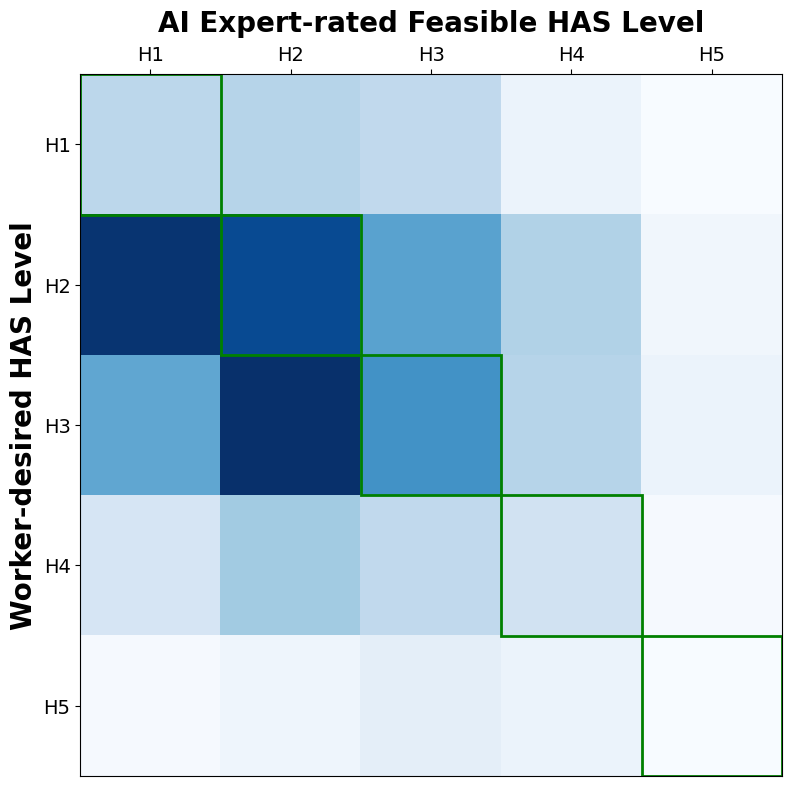

In [2]:
import matplotlib.patches as mpatches

dominant_level = [
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]  # dominant_level[i][j]: # of tasks with worker desire level i+1 and capability level j+1

for occ, tasks in occupation_to_tasks.items():
    for task in tasks:
        valid_users = demographics[demographics["Occupation (O*NET-SOC Title)"] == occ]["User ID"]
        task_responses = domain_worker_desires[
            (domain_worker_desires["User ID"].isin(valid_users)) &
            (domain_worker_desires["Task"]==task)
        ]
        task_expert = expert_ratings[expert_ratings["Task"]==task]
    
        worker_hist = task_responses["Human Agency Scale Rating"].value_counts(normalize=True).sort_index()
        expert_hist = task_expert["Human Agency Scale Rating"].value_counts(normalize=True).sort_index()
    
        worker_y = [worker_hist.get(i, 0) for i in range(1, 6)]
        expert_y = [expert_hist.get(i, 0) for i in range(1, 6)]
    
        worker_dominant_level = worker_y.index(max(worker_y))
        expert_dominant_level = expert_y.index(max(expert_y))
    
        dominant_level[worker_dominant_level][expert_dominant_level] += 1

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(dominant_level, cmap='Blues')

# Show x‐ticks at the top only
ax.set_xticks(range(5))
ax.set_xticklabels([f'H{i+1}' for i in range(5)], fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.tick_params(bottom=False)  # turn off bottom ticks

# Show y‐ticks normally on the left
ax.set_yticks(range(5))
ax.set_yticklabels([f'H{i+1}' for i in range(5)], fontsize=14)

# Move x‐axis label to the top
ax.set_xlabel('AI Expert-rated Feasible HAS Level', fontsize=20, labelpad=10, fontdict={'weight': 'bold'})
ax.xaxis.set_label_position('top')

# Y‐axis label stays on the left
ax.set_ylabel('Worker-desired HAS Level', fontsize=20, fontdict={'weight': 'bold'})

for i in range(5):
    # Highlight the diagonal cells (where i == j) with a green rectangle
    rect = mpatches.Rectangle(
        (i - 0.5, i - 0.5),  # (x, y) lower‐left corner
        1,                   # width of 1 cell
        1,                   # height of 1 cell
        fill=False,
        edgecolor='green',
        linewidth=2
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [3]:
print(dominant_level)
print(f"Total tasks: {sum(sum(row) for row in dominant_level)}")
print(f"Percentage of tasks in the diagonal: {sum(dominant_level[i][i] for i in range(5)) / sum(sum(row) for row in dominant_level) * 100}%")
print(f"Percentage of tasks in the lower triangle: {sum(dominant_level[i][j] for i in range(5) for j in range(i)) / sum(sum(row) for row in dominant_level) * 100}%")

[[32, 34, 30, 7, 0], [112, 102, 63, 36, 4], [61, 114, 71, 34, 7], [19, 41, 30, 22, 1], [1, 5, 11, 7, 0]]
Total tasks: 844
Percentage of tasks in the diagonal: 26.895734597156395%
Percentage of tasks in the lower triangle: 47.51184834123222%


In [4]:
import numpy as np, textwrap, matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def plot_has_for_occupation(occupation, file_path=None, add_legend=False, add_worker_desire_level=False, add_expert_desire_level=False):
    if occupation not in occupation_to_tasks:
        print(f"No valid tasks for occupation: {occupation}")
        return

    # ---------- data prep (unchanged) ----------
    tasks = occupation_to_tasks[occupation]
    valid_users = demographics[demographics["Occupation (O*NET-SOC Title)"] == occupation]["User ID"]
    occ_responses = domain_worker_desires[(domain_worker_desires["User ID"].isin(valid_users)) &
                                          (domain_worker_desires["Task"].isin(tasks))]
    occ_expert    = expert_ratings[expert_ratings["Task"].isin(tasks)]

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="none")
    fig.patch.set_facecolor("none") ; ax.set_facecolor("none")
    
    # put this right after you create `ax`
    for side in ("left", "right", "top", "bottom"):
        ax.spines[side].set_visible(True)      # make sure every spine is on
        ax.spines[side].set_linewidth(1.5)     # optional: make it easier to see
        ax.spines[side].set_edgecolor("black") # choose a color that contrasts
    
    ax.grid(
        True,
        color="gray",    # <- light-gray grid lines
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,       # transparency to keep them subtle
        zorder=0         # keep the grid behind your lines
    )


    # reserve the top 18 % of the canvas for the title –  
    fig.tight_layout(rect=[0, 0, 1, 0.82])

    # ---------- title (goes outside the rect) ----------
    if occupation == "Sales Representatives, Wholesale and Manufacturing, Technical and Scientific Products":
        occupation_title = "Sales Representatives"
    elif occupation == "Secretaries and Administrative Assistants, Except Legal, Medical, and Executive":
        occupation_title = "Secretaries and Admin Assistants"
    elif occupation == "Purchasing Agents, Except Wholesale, Retail, and Farm Products":
        occupation_title = "Purchasing Agents"
    elif occupation == "Securities, Commodities, and Financial Services Sales Agents":
        occupation_title = "Financial Services Sales Agents"
    elif occupation == "Bookkeeping, Accounting, and Auditing Clerks":
        occupation_title = "Bookkeeping and Accounting Clerks"
    elif occupation == "Eligibility Interviewers, Government Programs":
        occupation_title = "Eligibility Interviewers"
    elif occupation == "Medical Secretaries and Administrative Assistants":
        occupation_title = "Medical Secretaries"
    elif occupation == "Insurance Claims and Policy Processing Clerks":
        occupation_title = "Insurance Claims Clerks"
    elif occupation == "Software Quality Assurance Analysts and Testers":
        occupation_title = "Software Quality Assurance Analysts"
    elif occupation == "News Analysts, Reporters, and Journalists":
        occupation_title = "News Analysts, Reporters & Journalists"
    elif occupation == "Computer and Information Systems Managers":
        occupation_title = "Computer & Information Systems Managers"
    elif occupation == "Appraisers and Assessors of Real Estate":
        occupation_title = "Appraisers & Assessors of Real Estate"
    elif occupation == "Legal Secretaries and Administrative Assistants":
        occupation_title = "Legal Secretaries"
    elif occupation == "Computer and Information Research Scientists":
        occupation_title = "Computer & Information Research Scientists"
    elif occupation == "Mechanical Engineering Technologists and Technicians":
        occupation_title = "Mechanical Engineering Technologists"
    elif occupation == "Reservation and Transportation Ticket Agents and Travel Clerks":
        occupation_title = "Reservation Agents & Travel Clerks"
    else:
        occupation_title = occupation
        
    wrapped = textwrap.fill(occupation_title, width=23)
    n_lines = wrapped.count("\n") + 1            # how many lines?

    # add 0.02 (≈ 2 % of the figure height) below single-line titles
    extra_gap = 0.02 if n_lines == 1 else 0
    
    fig.subplots_adjust(
        left=0.12,   # 10 % of width
        right=0.88,
        bottom=0.12, # 12 % of height → protects x-tick labels
        top=0.80,    # matches the title anchor
    )

    title_txt = fig.suptitle(
        wrapped,
        y=0.80 + extra_gap,             # same as rect top
        ha="center",
        va="bottom",        # anchor *bottom* of title here
        fontsize=38,
        fontweight="bold",
    )

    # ---------- plot ----------
    x_labels = ["1","2","3","4","5"]
    ax.set_xticks(range(len(x_labels)));  ax.set_xticklabels(x_labels, fontsize=40)
    ax.set_yticklabels([])

    worker_hist = occ_responses["Human Agency Scale Rating"].value_counts(normalize=True).sort_index()
    expert_hist = occ_expert   ["Human Agency Scale Rating"].value_counts(normalize=True).sort_index()
    worker_y = np.array([worker_hist.get(i,0) for i in range(1,6)])
    expert_y = np.array([expert_hist.get(i,0) for i in range(1,6)])

    ax.plot(x_labels, worker_y, lw=3, color="blue", label="Worker-Desired Level")
    ax.plot(x_labels, expert_y, lw=3, color="red",  label="Expert-Rated Feasible Level")

    js = jensenshannon(worker_y, expert_y, base=2)
    if add_legend:
        ax.text(0.03, 0.95, f"Jensen-Shannon Distance\n= {js:.3f}", transform=ax.transAxes,
            fontsize=32, fontweight="bold", va="top", ha="left")
    else:
        ax.text(0.03, 0.95, f"JSD = {js:.3f}", transform=ax.transAxes,
                fontsize=38, fontweight="bold", va="top", ha="left")
    
    if add_worker_desire_level:
        peak_idx   = worker_y.argmax()
        peak_level = peak_idx
        peak_x     = peak_idx
        peak_y     = worker_y[peak_idx]

        # draw an arrow + label just above the peak point
        ax.annotate(
            f"H{peak_level+1}",
            xy=(peak_x, peak_y),
            xytext=(peak_x, peak_y + 0.08),
            textcoords="data",
            ha="center",
            va="bottom",
            fontsize=32,
            fontweight="bold",
            arrowprops=dict(
                arrowstyle="->",
                lw=2,
                color="blue",
                shrinkA=0,
                shrinkB=5,
            )
        )
    
    if add_expert_desire_level:
        peak_idx   = expert_y.argmax()
        peak_level = peak_idx
        peak_x     = peak_idx
        peak_y     = expert_y[peak_idx]

        # draw an arrow + label just above the peak point
        ax.annotate(
            f"H{peak_level+1}",
            xy=(peak_x, peak_y),
            xytext=(peak_x, peak_y + 0.08),
            textcoords="data",
            ha="center",
            va="bottom",
            fontsize=32,
            fontweight="bold",
            arrowprops=dict(
                arrowstyle="->",
                lw=2,
                color="red",
                shrinkA=0,
                shrinkB=5,
            )
        )

    ax.set_ylim(0,1); ax.grid(True, ls="--", lw=.5, alpha=.7)
    if add_legend:
        legend = ax.legend(
            loc="upper left",
            fontsize=25,
            frameon=True,
            bbox_to_anchor=(0, 0.8),
            handlelength=2,
        )
        legend.get_frame().set_facecolor('none')
        legend.get_frame().set_edgecolor('grey')
        legend.get_frame().set_boxstyle('round,pad=0.1')  # rounded corners

    # ---------- output ----------
    if file_path:
        plt.savefig(file_path, dpi=300,
                    facecolor="none", transparent=True)
        plt.close(fig)
    else:
        plt.show()

    return js, worker_y.argmax(), expert_y.argmax()


In [5]:
occupation_info = {
    "occupation": [],
    "js_distance": [],
    "worker_desire_dominant_level": [],
    "capability_dominant_level": []
}

for occ in occupation_to_tasks.keys():
    file_name = occ.replace(" ", "_").replace("/", "_")
    js_dist, worker_desire_dominant_level, capability_dominant_level = plot_has_for_occupation(occ, file_path=f"../local/has/{file_name}.png", add_legend=False)
    occupation_info["occupation"].append(occ)
    occupation_info["js_distance"].append(js_dist)
    occupation_info["worker_desire_dominant_level"].append(worker_desire_dominant_level)
    occupation_info["capability_dominant_level"].append(capability_dominant_level)

In [6]:
pd.DataFrame(occupation_info).to_csv("../local/has/occupation_info.csv", index=False)

In [7]:
for occ in occupation_to_tasks.keys():
    file_name = occ.replace(" ", "_").replace("/", "_")
    js_dist, worker_desire_dominant_level, capability_dominant_level = plot_has_for_occupation(occ, file_path=f"../local/has_with_worker_desire_level/{file_name}.png", add_legend=False, add_worker_desire_level=True)

In [8]:
for occ in occupation_to_tasks.keys():
    file_name = occ.replace(" ", "_").replace("/", "_")
    js_dist, worker_desire_dominant_level, capability_dominant_level = plot_has_for_occupation(occ, file_path=f"../local/has_with_expert_level/{file_name}.png", add_legend=False, add_expert_desire_level=True)

In [9]:
avg_worker_has_rating = domain_worker_desires.groupby("Task").agg({
    "Human Agency Scale Rating": "mean",
    "Physical Action Requirement": "mean",
    "Interpersonal Communication Requirement": "mean",
    "Involved Uncertainty": "mean",
    "Domain Expertise Requirement": "mean"
}).reset_index()
avg_expert_has_rating = expert_ratings.groupby("Task").agg({
    "Human Agency Scale Rating": "mean",
    "Physical Action Requirement": "mean",
    "Interpersonal Communication Requirement": "mean",
    "Involved Uncertainty": "mean",
    "Domain Expertise Requirement": "mean"
}).reset_index()

task_to_occ = (
    domain_worker_desires[["Task", "Occupation (O*NET-SOC Title)"]]
    .drop_duplicates(subset="Task")
)

merged_has_rating = pd.merge(avg_worker_has_rating, avg_expert_has_rating, on="Task", suffixes=("_worker", "_expert"))
merged_has_rating = pd.merge(merged_has_rating, task_to_occ, on="Task")

In [10]:
# Compute Spearman Correlation
from scipy.stats import spearmanr
correlation_results = {}
for column in ["Human Agency Scale Rating", "Physical Action Requirement", 
               "Interpersonal Communication Requirement", "Involved Uncertainty", 
               "Domain Expertise Requirement"]:
    corr, p_value = spearmanr(merged_has_rating[f"{column}_worker"], merged_has_rating[f"{column}_expert"])
    correlation_results[column] = {"correlation": corr, "p_value": p_value}

for column, result in correlation_results.items():
    print(f"{column}: Correlation = {result['correlation']:.3f}, p-value = {result['p_value']}")

Human Agency Scale Rating: Correlation = 0.247, p-value = 3.46960658184982e-13
Physical Action Requirement: Correlation = 0.177, p-value = 2.3410676846108225e-07
Interpersonal Communication Requirement: Correlation = 0.370, p-value = 7.464347266602612e-29
Involved Uncertainty: Correlation = 0.310, p-value = 2.647414100935455e-20
Domain Expertise Requirement: Correlation = 0.325, p-value = 2.982480543416515e-22


In [11]:
# Print overall average of worker and expert ratings
for column in ["Human Agency Scale Rating", "Physical Action Requirement", 
               "Interpersonal Communication Requirement", "Involved Uncertainty", 
               "Domain Expertise Requirement"]:
    worker_avg = merged_has_rating[f"{column}_worker"].mean()
    expert_avg = merged_has_rating[f"{column}_expert"].mean()
    print(f"Average {column} - Worker: {worker_avg:.2f}, Expert: {expert_avg:.2f}")

# Print average of "Editors" occupation
editors_avg = merged_has_rating[merged_has_rating["Occupation (O*NET-SOC Title)"] == "Editors"]
for column in ["Human Agency Scale Rating", "Physical Action Requirement", 
               "Interpersonal Communication Requirement", "Involved Uncertainty", 
               "Domain Expertise Requirement"]:
    worker_avg = editors_avg[f"{column}_worker"].mean()
    expert_avg = editors_avg[f"{column}_expert"].mean()
    print(f"Editors - Average {column} - Worker: {worker_avg:.2f}, Expert: {expert_avg:.2f}")

# Print average of "Mathematicians" occupation
mathematicians_avg = merged_has_rating[merged_has_rating["Occupation (O*NET-SOC Title)"] == "Mathematicians"]
for column in ["Human Agency Scale Rating", "Physical Action Requirement", 
               "Interpersonal Communication Requirement", "Involved Uncertainty", 
               "Domain Expertise Requirement"]:
    worker_avg = mathematicians_avg[f"{column}_worker"].mean()
    expert_avg = mathematicians_avg[f"{column}_expert"].mean()
    print(f"Mathematicians - Average {column} - Worker: {worker_avg:.2f}, Expert: {expert_avg:.2f}")

# Print average of "Aerospace Engineers"
aerospace_engineers_avg = merged_has_rating[merged_has_rating["Occupation (O*NET-SOC Title)"] == "Aerospace Engineers"]
for column in ["Human Agency Scale Rating", "Physical Action Requirement", 
               "Interpersonal Communication Requirement", "Involved Uncertainty", 
               "Domain Expertise Requirement"]:
    worker_avg = aerospace_engineers_avg[f"{column}_worker"].mean()
    expert_avg = aerospace_engineers_avg[f"{column}_expert"].mean()
    print(f"Aerospace Engineers - Average {column} - Worker: {worker_avg:.2f}, Expert: {expert_avg:.2f}")

Average Human Agency Scale Rating - Worker: 2.87, Expert: 2.61
Average Physical Action Requirement - Worker: 2.07, Expert: 1.68
Average Interpersonal Communication Requirement - Worker: 2.79, Expert: 2.35
Average Involved Uncertainty - Worker: 2.76, Expert: 2.40
Average Domain Expertise Requirement - Worker: 3.13, Expert: 3.05
Editors - Average Human Agency Scale Rating - Worker: 3.27, Expert: 3.23
Editors - Average Physical Action Requirement - Worker: 1.99, Expert: 1.80
Editors - Average Interpersonal Communication Requirement - Worker: 3.31, Expert: 3.70
Editors - Average Involved Uncertainty - Worker: 3.10, Expert: 2.79
Editors - Average Domain Expertise Requirement - Worker: 3.40, Expert: 3.83
Mathematicians - Average Human Agency Scale Rating - Worker: 3.14, Expert: 3.57
Mathematicians - Average Physical Action Requirement - Worker: 1.73, Expert: 1.27
Mathematicians - Average Interpersonal Communication Requirement - Worker: 2.16, Expert: 1.93
Mathematicians - Average Involved Un

In [12]:
# Print the average scores for tasks that have dominant worker-desired level 5
tasks_with_dominant_worker_h5 = []
tasks_with_dominant_expert_h5 = []
for occ, tasks in occupation_to_tasks.items():
    valid_users = demographics[demographics["Occupation (O*NET-SOC Title)"] == occ]["User ID"]
    occ_responses = domain_worker_desires[
        (domain_worker_desires["User ID"].isin(valid_users)) &
        (domain_worker_desires["Task"].isin(tasks))
    ]
    worker_hist = occ_responses["Human Agency Scale Rating"].value_counts(normalize=True).sort_index()
    worker_y = [worker_hist.get(i, 0) for i in range(1, 6)]
    
    if worker_y.index(max(worker_y)) == 4:  # dominant worker-desired level is 5
        tasks_with_dominant_worker_h5.extend(tasks)
    
    expert_hist = expert_ratings[expert_ratings["Task"].isin(tasks)]["Human Agency Scale Rating"].value_counts(normalize=True).sort_index()
    expert_y = [expert_hist.get(i, 0) for i in range(1, 6)]
    if expert_y.index(max(expert_y)) == 4:  # dominant expert-rated level is 5
        tasks_with_dominant_expert_h5.extend(tasks)
    
tasks_with_dominant_worker_h5_avg = merged_has_rating[merged_has_rating["Task"].isin(tasks_with_dominant_worker_h5)]
tasks_with_dominant_expert_h5_avg = merged_has_rating[merged_has_rating["Task"].isin(tasks_with_dominant_expert_h5)]
for column in ["Human Agency Scale Rating", "Physical Action Requirement", 
               "Interpersonal Communication Requirement", "Involved Uncertainty", 
               "Domain Expertise Requirement"]:
    worker_avg = tasks_with_dominant_worker_h5_avg[f"{column}_worker"].mean()
    expert_avg = tasks_with_dominant_worker_h5_avg[f"{column}_expert"].mean()
    print(f"Tasks with dominant worker-desired level 5 - Average {column} - {worker_avg}")
    print(f"Tasks with dominant expert-assessed level 5 - Average {column} - {expert_avg}")


Tasks with dominant worker-desired level 5 - Average Human Agency Scale Rating - 3.273989898989899
Tasks with dominant expert-assessed level 5 - Average Human Agency Scale Rating - 3.227272727272727
Tasks with dominant worker-desired level 5 - Average Physical Action Requirement - 1.993181818181818
Tasks with dominant expert-assessed level 5 - Average Physical Action Requirement - 1.803030303030303
Tasks with dominant worker-desired level 5 - Average Interpersonal Communication Requirement - 3.3138888888888887
Tasks with dominant expert-assessed level 5 - Average Interpersonal Communication Requirement - 3.696969696969697
Tasks with dominant worker-desired level 5 - Average Involved Uncertainty - 3.102272727272727
Tasks with dominant expert-assessed level 5 - Average Involved Uncertainty - 2.7878787878787876
Tasks with dominant worker-desired level 5 - Average Domain Expertise Requirement - 3.3972222222222217
Tasks with dominant expert-assessed level 5 - Average Domain Expertise Requir